In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from typing import NamedTuple

from functools import partial

jax.config.update("jax_enable_x64", True)

In [5]:
class CutCubic(NamedTuple):
    cubic:   float
    square:  float
    offset:  float

class Shape(NamedTuple):
    width: float
    depth: float
    length: float
    elements: int
    min_depth: float
    # assert elements % 2 = 0

    # def num_subdivisions(self):
    #     return (self.elements // 2) + 1

class Bar(NamedTuple):
    xmids: jnp.ndarray
    depths: jnp.ndarray
    length_per_element: float

    def plot(self, to_scale=True):
        plt.plot(bar.xmids, bar.depths)
        plt.plot(bar.xmids, jnp.full(bar.xmids.shape, 0))
        if to_scale:
            plt.gca().set_aspect('equal')

class Consts(NamedTuple):
    def make_E_G(rho: float, E: float, G: float):
        return Consts(rho = rho, E = E, G = G, nu = (E / (2 * G)) - 1)
    def make_G_nu(rho: float, G: float, nu: float):
        return Consts(rho = rho, E = 2 * G * (1 + nu), G = G, nu = nu)
    def make_E_nu(rho: float, E: float, nu: float):
        return Consts(rho = rho, E = E, G = E / (2 * (1 + nu)), nu = nu)
    
    # density (kg / m^3)
    rho: float
    # Young's modulus (Pa) or elastic modulus: https://en.wikipedia.org/wiki/Young%27s_modulus
    # Typically, wood is on the order of 10 gigapascals (10e9)
    # E = 2 * G * (1 + nu)
    E: float
    # Shear modulus (Pa): https://en.wikipedia.org/wiki/Shear_modulus
    # Typically, wood is on the order of 4 gigapascals (4e9)
    G: float
    # Poisson's ratio: https://en.wikipedia.org/wiki/Poisson%27s_ratio
    # Most materials between 0.0 and 0.5; typically 0.2 to 0.3
    nu: float

class SweepTimoshenko(NamedTuple):
    start_freq: float
    stop_freq: float
    num_freq: int
    bisect_iters: int

sweep_default = SweepTimoshenko(start_freq = 100, stop_freq = 10000, num_freq = 600, bisect_iters = 40)

In [6]:
tasmanian_oak = Consts.make_E_G(E = 6.067e9, G = 16.0303e9, rho = 611.0152)
# https://vicbeam.com.au/product-information/
# E = 21,000MPa; G = 1,400MPa, rho = 990kg/m^3
# https://www.wood-database.com/spotted-gum/
# E = 19.77GPa; rho = 940kg/m^3
spotted_gum = Consts.make_E_G(E = 21.000e9, G = 1.4e9, rho = 990)

# eastern indian rosewood
# https://www.matweb.com/search/datasheet.aspx?matguid=e3b5a2a1a6794cddb47a91fbea57c18a&ckck=1
# eastern_indian_rosewood = Consts(E = 

# Eucalyptus hemilampra
# https://www.matweb.com/search/DataSheet.aspx?MatGUID=1022bc4dd73149399e4ad53d386cf458
# Eucalyptus globulus
# https://www.matweb.com/search/DataSheet.aspx?MatGUID=a246917e73594287b60e9338f85d511e

# From supermediocre http://supermediocre.org/index.php/rich/richs-projects/xylophone-project/
rosewood = Consts.make_E_G(E = 23.7e9, G = 19e9, rho = 1082)


# Test from Numerical simulations of xylophones. I. Time-domain modeling of the vibrating bars (Chaigne, Doutaut, 1997)
# Inferred properties from supermediocre
wood_test_chaigne1997 = Consts.make_E_nu(E = 9.54E9, nu = 0.3, rho = 1015)


In [8]:
spotted_gum.nu, tasmanian_oak.nu, rosewood.nu

(6.5, -0.8107646145112692, -0.37631578947368416)

In [9]:
def make_bar_cubic(shape: Shape, cut: CutCubic) -> jnp.ndarray:
    # length of each section
    l = shape.length / shape.elements
    # midpoint of each section
    x = jnp.linspace(0 + l/2, shape.length / 2 - l/2, shape.elements // 2)
    # cut-out
    y = cut.cubic * (x ** 3) + cut.square * (x ** 2) + cut.offset
    # clamped
    yclamp = jnp.maximum(jnp.minimum(y, shape.depth), shape.min_depth)
    
    xmids = jnp.append( - jnp.flip(x), x)
    depths = jnp.append( jnp.flip(yclamp), yclamp)
    return Bar(xmids = xmids, depths = depths, length_per_element = l)

In [10]:
shape = Shape(width = 0.040, depth = 0.020, length = 0.450, elements = 300, min_depth = 0.010)
cut = CutCubic(1.0, 1.0, 0.018)
bar = make_bar_cubic(shape, cut)
# bar

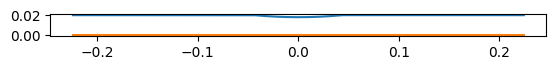

In [11]:
bar.plot()

In [12]:
def shear_factor_timoshenko(nu, w, b, num_terms = 15):
    # shear factor - overridden in matlab
    lambdas = jnp.full_like(b, 5/6)
    return lambdas

In [16]:
def recept_timoshenko(consts: Consts, shape: Shape, bar: Bar, w: float):
    I = shape.width * bar.depths ** 3 / 12
    EI = consts.E * I
    area = shape.width * bar.depths
    lam = shear_factor_timoshenko(consts.nu, shape.width, bar.depths)
    
    lens = jnp.full_like(bar.depths, bar.length_per_element)
    
    aplus = 1 + consts.E / (lam * consts.G)
    aminus = 1 - consts.E / (lam * consts.G)
    
    flipsign = w * w < lam * consts.G * area / (consts.rho * I)
    sign = jnp.where(flipsign, 1, -1)
    
    m   = consts.rho * I * w * w
    n   = jnp.sqrt(m * (m * aminus ** 2 + 4 * consts.E * area))
    eta = jnp.sqrt(((-sign * m * aplus) + sign * n) / 2 * EI)
    xi  = jnp.sqrt(((m * aplus) + n) / (2*EI))
    s   = consts.rho * w * w / (lam * consts.G * xi) - xi
    r   = consts.rho * w * w / (lam * consts.G * eta) + sign * eta
    e   = r * eta ** 2 / (s * xi ** 2)
    xi_len  = xi * lens
    eta_len = eta * lens
    c   = jnp.cos(xi_len)
    ch  = jnp.cosh(eta_len)
    si  = jnp.sin(xi_len)
    sh  = jnp.sinh(eta_len)
    f1  = si * sh
    f2  = c * ch
    f3  = f2 - 1
    f4  = si * ch
    f5  = c * sh
    f6  = c - ch
    recip_delta = 1 / (consts.rho * w * w * area * (2 - 2 * f2 + sign * (e + -sign / e)*f1))
    
    b11 = -sign * f5 * (r * eta ** 2 / (s * xi) - eta) + f4 * (s * xi ** 2 / (r * eta) - xi)
    b12 = -sign * f3 * (s * xi + r * eta) + -sign * f1 * (r * eta ** 2 / xi + -sign * s * xi ** 2 / eta)
    b22 = f4 * r * eta * (s - r * eta / xi) + f5 * s * xi * (r - s * xi / eta)

    # add all of the remaining sections in section C
    # signs_ref=[-1 1 1 1 -1 -1 -1 -1 -1 1   1 -1 -1  1];
    #             1 2 3 4  5  6  7  8  9 10 11 12 13 14
    gamma1_11 = b11 # -sign * f5 * (r * eta ** 2 / (s * xi) - eta) + f4 * (s * xi ** 2 / (r * eta) - xi)
    gamma1_12 = -b12 # sign * f3 * (s * xi + r * eta) + sign * f1 * (r * eta ** 2 / xi + -sign * s * xi ** 2 / eta)
    gamma1_22 = b22 # f4 * r * eta * (s - r * eta / xi) + f5 * s * xi * (r - s * xi / eta)
    
    gamma1 = recip_delta * jnp.array([[ gamma1_11, gamma1_12 ], [ gamma1_12, gamma1_22 ]])
    
    gamma2_11 = -sign * sh * (r * eta ** 2 / (s * xi) - eta) + si * (s * xi ** 2 / (r * eta) - xi)
    gamma2_12 = -sign * f6 * (r * eta - s * xi)
    gamma2_21 = -gamma2_12 # sign * f6 * (r * eta - s * xi)
    gamma2_22 = sh * (r * s * xi - s ** 2 * xi ** 2 / eta) + si * (r * s * eta - r ** 2 * eta ** 2 / xi)
    gamma2 = recip_delta * jnp.array([[ gamma2_11, gamma2_12 ], [ gamma2_21, gamma2_22 ]])
    
    gamma3 = gamma1 * jnp.array([[ [1], [-1] ], [ [-1], [1]]])
    
    beta0 = recip_delta[0] * jnp.array([ [ b11[0], b12[0] ], [ b12[0], b22[0] ] ]);
    
    result = jax.lax.fori_loop(1, shape.elements, lambda k, beta: gamma3.T[k] - gamma2.T[k].T * jnp.linalg.solve(gamma1.T[k] + beta, gamma2.T[k]), beta0)
    return result

def recept_timoshenko_11(consts: Consts, shape: Shape, bar: Bar, w: float):
    return recept_timoshenko(consts, shape, bar, w)[0,0]

In [17]:
recept_timoshenko(rosewood, shape, bar, 100)

Array([[-1.90989468e-04,  5.96427712e-04],
       [ 5.96825785e-04,  5.19761205e-01]], dtype=float64)

-0.0002879889915914039 0.0001114169351504758


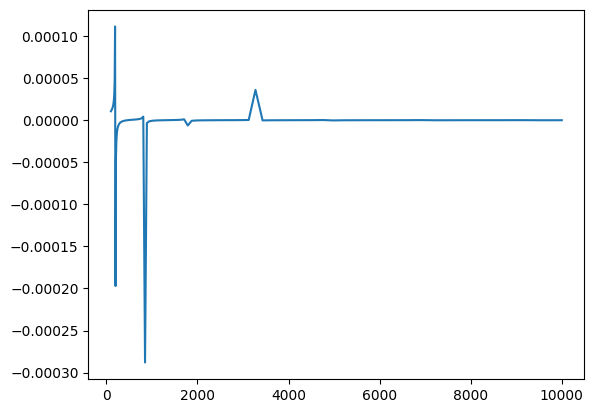

In [19]:
StartFreq = 100
StopFreq = 10000
NumFreq = 100

shape = Shape(width = 0.040, depth = 0.020, length = 0.450, elements = 300, min_depth = 0.010)
cut = CutCubic(1, 1, 0.018)
bar = make_bar_cubic(shape, cut)

sweep = jnp.logspace(jnp.log10(StartFreq), jnp.log10(StopFreq), NumFreq)
recepts = jax.vmap(lambda w: recept_timoshenko_11(rosewood, shape, bar, 2 * jnp.pi * w))(sweep)
# plt.loglog(sweep / (2 * jnp.pi), recepts)
# plt.semilogx(sweep / (2 * jnp.pi), recepts)
plt.plot(sweep, recepts)

print(jnp.min(recepts), jnp.max(recepts))



In [20]:
def bracket_natfreq(sweep: jnp.ndarray, recepts: jnp.ndarray):
    sweeprecepts = jnp.stack([sweep, recepts]).T
    
    def bracket_go(pre, now):
        # (pre, k) = prek
        (pre_freq, pre_v) = (pre[0], pre[1])
        (now_freq, now_v) = (now[0], now[1])
        return (now, jnp.array([pre_freq, now_freq, jnp.logical_and(pre_v >= 0, now_v < 0)]))
    _, brackets = jax.lax.scan(bracket_go, jnp.array([-1.0, -1.0]), sweeprecepts)
    
    nz = brackets[brackets[:,2].nonzero(size = 3, fill_value = 0)]
    return nz

In [21]:
brackets = bracket_natfreq(sweep, recepts)
brackets

Array([[1.91791026e+02, 2.00923300e+02, 1.00000000e+00],
       [8.11130831e+02, 8.49753436e+02, 1.00000000e+00],
       [1.70735265e+03, 1.78864953e+03, 1.00000000e+00]], dtype=float64)

In [22]:
def find_freq_timo(consts: Consts, shape: Shape, bar: Bar, bracket: jnp.ndarray, iters = 40, tolerance = 0.0001):
    wlo = bracket[0]
    whi = bracket[1]
    ylo = recept_timoshenko_11(consts, shape, bar, 2 * jnp.pi * wlo)
    yhi = recept_timoshenko_11(consts, shape, bar, 2 * jnp.pi * whi)

    estimate = whi
    dw = wlo - whi
    state0 = jnp.array([estimate, dw])
    def go(k: int, state: jnp.ndarray) -> jnp.ndarray:
        estimate = state[0]
        dw = state[1] * 0.5
        wmid = estimate + dw
        ymid = recept_timoshenko_11(consts, shape, bar, 2 * jnp.pi * wmid)
        estimate = jnp.where(ymid <= 0, wmid, estimate)
        # jax.debug.print("{estimate}: {ymid}", estimate=estimate, ymid=ymid)
        return jnp.array([estimate, dw])
        
    return jax.lax.fori_loop(0, iters, go, state0).T[0]


In [24]:
jax.vmap(lambda br: find_freq_timo(rosewood, shape, bar, br))(brackets)

Array([ 197.74126093,  849.22352905, 1777.27196722], dtype=float64)

In [25]:
class SweepResult(NamedTuple):
    sweep: jnp.ndarray
    recepts: jnp.ndarray
    harmonics: jnp.ndarray

def sweep_timoshenko(consts: Consts, shape: Shape, bar: Bar, sweep_opts: SweepTimoshenko):
    sweep = jnp.logspace(jnp.log10(sweep_opts.start_freq), jnp.log10(sweep_opts.stop_freq), sweep_opts.num_freq)
    recepts = jax.vmap(lambda w: recept_timoshenko_11(consts, shape, bar, 2 * jnp.pi * w))(sweep)
    # plt.loglog(sweep / (2 * jnp.pi), recepts)
    # plt.semilogx(sweep / (2 * jnp.pi), recepts)
    # plt.plot(sweep, recepts)
    # print(jnp.min(recepts), jnp.max(recepts))

    brackets = bracket_natfreq(sweep, recepts)
    freqs = jax.vmap(lambda br: find_freq_timo(consts, shape, bar, br))(brackets)
    return SweepResult(sweep = sweep, recepts = recepts, harmonics = freqs)

In [27]:
recept_timoshenko(rosewood, shape, bar, 2672.367 * 2 * jnp.pi)
cut

CutCubic(cubic=1, square=1, offset=0.018)

Array([ 450.84809956, 1781.46432492, 3931.00127302], dtype=float64)

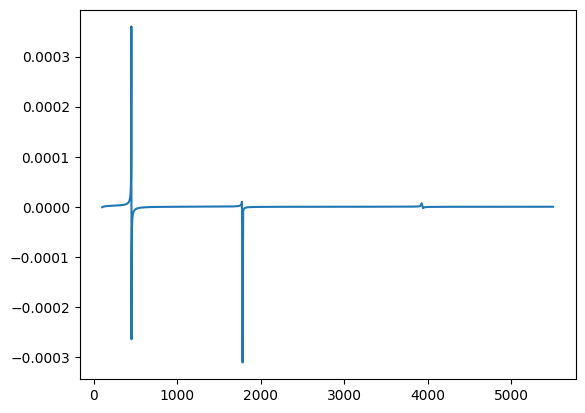

In [46]:
# sweep = sweep_timoshenko(consts, shape, bar, sweep)
sweep = sweep_timoshenko(rosewood, shape, bar, SweepTimoshenko(start_freq=100, stop_freq=5500, num_freq=1000, bisect_iters=40))
plt.plot(sweep.sweep, sweep.recepts)
# plt.semilogx(sweep.sweep, sweep.recepts)
sweep.harmonics
# print(jnp.stack([sweep.sweep, sweep.recepts]).T)

In [30]:
@partial(jax.jit, static_argnames=['consts', 'shape', 'sweep_opts'])
def loss(cut: CutCubic, consts: Consts, shape: Shape, sweep_opts: SweepTimoshenko, target: jnp.ndarray, weights: jnp.ndarray = jnp.array([1.0, 0.5, 0.25])):
    bar = make_bar_cubic(shape, cut)
    # jax.debug.print("{c}; {b}", c = cut, b = bar.depths)
    sweep = sweep_timoshenko(consts, shape, bar, sweep_opts)
    diff = jnp.abs((target - sweep.harmonics) / target)
    loss = diff * weights
    # jax.debug.print("{c} T {t}; A {h}: loss {d}", c = cut, t = target, h = sweep.harmonics, d = loss)
    return jnp.sum(loss)
    

In [31]:
import scipy


Optimization terminated successfully.
         Current function value: 0.045516
         Iterations: 204
         Function evaluations: 381
[0.00949981 0.01156012 0.01901974]


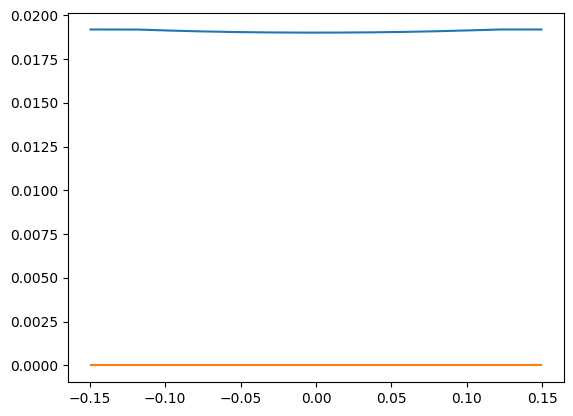

In [33]:
tasmanian_oak = Consts.make_E_G(E = 6.067e9, G = 16.0303e9, rho = 611.0152)
consts = tasmanian_oak
shape = Shape(width = 0.065, depth = 0.0192, length = 0.300, elements = 300, min_depth = 0.010)

target = 300 * jnp.array([1.0, 4.0, 9.8])

def scipy_go(x, consts, shape, sweep_default, target):
    cut = CutCubic(x[0], x[1], x[2])
    # consts, shape, sweep_default, target = args
    return loss(cut, consts, shape, sweep_default, target, weights = jnp.array([1.0, 0.8, 0.5]))

x = np.linspace(0, 1, 10)
y = np.linspace(0, 1, 10)
z = np.linspace(shape.min_depth, shape.depth, 10)
xv, yv, zv = np.meshgrid(x, y, z)

x0 = np.array([0.0, 0.0, 0.0192])
# x0 = np.array([0.5, 0.5, 0.01834])
r = scipy.optimize.fmin(scipy_go, x0, args = (consts, shape, sweep_default, target), ftol=1e-9, xtol=1e-9)
# r = scipy.optimize.minimize(scipy_go, x0, args = (consts, shape, sweep_default, target), tol = 1e-5) # , options = { 'maxiter': 100}) #, tol=1e-10)
# r = scipy.optimize.minimize(scipy_go, x0, args = (consts, shape, sweep_default, target))

print(r)

bar = make_bar_cubic(shape, CutCubic(r[0], r[1], r[2]))
bar.plot(to_scale = False)

In [35]:
%%time
x = np.linspace(0, 2, 5)
y = np.linspace(0, 2, 5)
z = np.linspace(shape.min_depth, shape.depth, 5)
xv, yv, zv = np.meshgrid(x, y, z)

# r = scipy.optimize.fmin(scipy_go, x0, args = (consts, shape, sweep_default, target), ftol=1e-9, xtol=1e-9)

losses = jax.vmap(lambda x, y, z: jnp.array([scipy_go(jnp.array([x, y, z]), consts, shape, sweep_default, target), x, y, z]))(xv.flatten(), yv.flatten(), zv.flatten())
best = jnp.argmin(losses, axis = 0)[0]
xyz = losses[best, 1:]

CPU times: user 11.6 s, sys: 1.52 s, total: 13.1 s
Wall time: 5.21 s


[0.     0.     0.0192]


Array([ 303.79820951, 1207.10488165, 2684.88637587], dtype=float64)

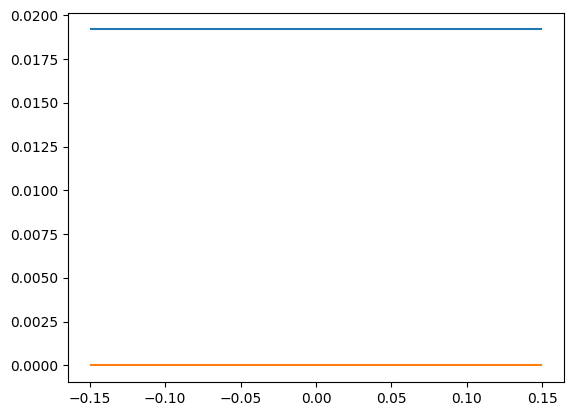

In [36]:
print(xyz)
bar = make_bar_cubic(shape, CutCubic(xyz[0], xyz[1], xyz[2]))
bar.plot(to_scale = False)

sweep = sweep_timoshenko(consts, shape, bar, sweep_default)
sweep.harmonics

In [37]:
def recept_loss(cut, consts, shape, ws):
    bar = make_bar_cubic(shape, cut)
    wsT = ws.T
    rs  = jax.vmap(lambda w: recept_timoshenko_11(consts, shape, bar, w))(wsT[0] * 2 * jnp.pi)
    # rs  = jnp.maximum(0.0, rs)
    # jax.debug.print("{c} T {t}; A {h}: loss {d}", c = cut, t = target, h = sweep.harmonics, d = loss)
    jax.debug.print("{rs}", rs=rs)
    return -jnp.dot(rs, wsT[1])

# cut = CutCubic(x[0], x[1], x[2])

# print(jax.grad(recept_loss, argnums=[0])(CutCubic(0.0, 0.0, 0.0192), consts, shape, jnp.array([[300, 1.0], [1200, 0.5], [2940, 0.25]])))
print(recept_loss(CutCubic(0.0, 0.0, 0.0192), consts, shape, jnp.array([[300, 1.0], [1200, 0.5], [2940, 0.25]])))
# print(recept_loss(CutCubic(0.0, 0.0, 0.0192), consts, shape, jnp.array([[300, 1.0], [1200, 0.5], [2940, 0.25]])))


[ 1.94525481e-04  2.57710823e-05 -2.63521243e-07]
-0.00020734514230708262


In [38]:
import optimistix

In [39]:
weights = jnp.array([[300, 1.0], [1200, 0.8], [2940, 0.6],
                     [200, -0.5], [301, -0.5],
                     [800, -0.4], [1201, -0.4],
                     [2000, -0.3], [2941, -0.3]])

solver = optimistix.GradientDescent(learning_rate = 1e-5, rtol = 1e-5, atol=1e-5)

res = optimistix.minimise(lambda x, args: recept_loss(CutCubic(x[0], x[1], x[2]), *args), solver, jnp.array([0.1, 0.1, 0.019]), args = (consts, shape, weights))
# res = optimistix.compat.minimize(lambda x, *args: recept_loss(CutCubic(x[0], x[1], x[2]), *args), jnp.array([0.1, 0.1, 0.019]), args = (consts, shape, weights), method = 'bfgs')
print(res)
res.value

[ 5.03072329e-04  1.86788741e-05 -2.50558822e-07  1.06571680e-05
  1.58772538e-03  3.68639183e-07  2.07793064e-05  6.22352605e-08
 -2.49372333e-07]
[ 1.94525481e-04  2.57710823e-05 -2.63521243e-07  1.04547750e-05
  2.62961887e-04  3.68153885e-07  2.99621022e-05  5.94080221e-08
 -2.62232370e-07]
[ 1.94525481e-04  2.57710823e-05 -2.63521243e-07  1.04547750e-05
  2.62961887e-04  3.68153885e-07  2.99621022e-05  5.94080221e-08
 -2.62232370e-07]
Solution(
  value=f64[3],
  result=EnumerationItem(
    _value=i32[],
    _enumeration=<class 'optimistix._solution.RESULTS'>
  ),
  aux=None,
  stats={'max_steps': 256, 'num_steps': i64[]},
  state=_GradientDescentState(
    first_step=bool[],
    y_eval=f64[3],
    search_state=None,
    f_info=EvalGrad(f=f64[], grad=f64[3]),
    aux=None,
    descent_state=_SteepestDescentState(grad=f64[3]),
    terminate=bool[],
    result=EnumerationItem(
      _value=i32[],
      _enumeration=<class 'optimistix._solution.RESULTS'>
    )
  )
)


Array([0.1       , 0.10000013, 0.01923142], dtype=float64)

[ 303.79820951 1207.10488165 2684.88637587]


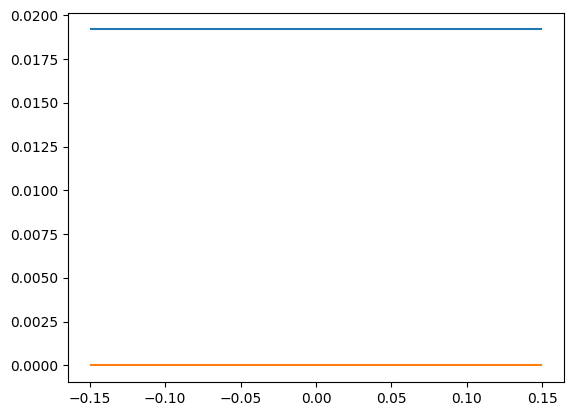

In [40]:
cut = CutCubic(res.value[0], res.value[1], res.value[2])
# cut = CutCubic(res.x[0], res.x[1], res.x[2])
# cut = CutCubic(0.0, 0.0, 0.0192)

bar = make_bar_cubic(shape, cut)
bar.plot(to_scale = False)

sweep = sweep_timoshenko(consts, shape, bar, sweep_default)
print(sweep.harmonics)